In [1]:
#importing libraries

import pandas as pd
import math
import numpy as np
from datetime import datetime,date
import pytz
import matplotlib.pyplot as plt
from IPython.core.ultratb import VerboseTB
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
VerboseTB._tb_highlight = "bg:#039dfc"
import scipy.optimize as spo
import time
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model
import requests
import json
from hyperopt import fmin, tpe, hp, Trials


2024-10-29 22:03:42.227001: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# class for technical indicators. I receives a dataframe and returns, for each method, 
# a new column with the values calculated based on an input column.

class TechnicalIndicators():
    def __init__(self, data_frame):
        self.df = data_frame.copy()

    # calculation of the return of column after an interval of n days
    def momentum(self, column, n, offset=0):
        if f'{column}_momentum_{n}*' not in self.df.columns:
            close_prices = self.df.loc[offset:,column]
            momentum = close_prices / close_prices.shift(n) - 1
            momentum[0:n]=1
            self.df[f'{column}_momentum_{n}'] = momentum
            
        return self.df[f'{column}_momentum_{n}']
    
    # moving average of column i of returns through n days
    def simple_movement_average(self, column, n, offset=0):
        if f'{column}_sma_{n}*' not in self.df.columns:
            window_mean = self.df.loc[offset:,column].rolling(n).mean()
            window_mean[0:n]=  window_mean[n]
            self.df[f'{column}_sma_{n}'] = self.df[column] / window_mean - 1
        return self.df[f'{column}_sma_{n}']
    
    # calculate upper and lower 2*std_deviation lines
    def _get_bollinger_bands(self, rm, rstd):
        upper_band = rm + rstd * 2
        lower_band = rm - rstd * 2
        return upper_band, lower_band
    
    # moving average and +/- 2*std_deviation lines
    def bollinger_bands(self, column, window_size=20, offset=0):
        if f'{column}_upper_band*' not in self.df.columns:
            self.df[f'{column}_mm20'] = self.df.loc[offset:,column].rolling(window_size).mean()
            self.df.loc[0:window_size,f'{column}_mm20'] =  self.df.loc[window_size,f'{column}_mm20']
            rstd = self.df.loc[offset:,column].rolling(window_size).std()
            rstd.iloc[0:window_size] = rstd.iloc[window_size]
            self.df[f'{column}_upper_band'], self.df[f'{column}_lower_band'] = self._get_bollinger_bands(self.df[f'{column}_mm20'], rstd)
        return self.df[[column, f'{column}_mm20', f'{column}_upper_band', f'{column}_lower_band']]
    
    # daily and cumulative returns of column
    def add_daily_return(self,column):
        self.df[f'{column}_daily_return'] = (self.df[column] / self.df[column].shift(1)) - 1
        self.df.loc[0,f'{column}_daily_return'] = 0
        self.df[f'{column}_cumulative_return'] = (self.df[column] / self.df[column].values[0]) - 1
        self.df.loc[0,f'{column}_cumulative_return'] = 0
        
    # log return after n days of column
    def log_returns(self,column,n):
        self.df[f'{column}_log_return_{n}'] = np.log((self.df[column] / self.df[column].shift(n)))
        self.df.loc[0:n,f'{column}_log_return_{n}'] = self.df.loc[n,f'{column}_log_return_{n}']
        return self.df[f'{column}_log_return_{n}']
    
    

In [3]:
# get stock (ticker) data from yahoo finance from start to end dates
class stock_dataframe():
    def __init__(self,ticker,start,end):
        self.ticker = ticker
        self.start = start 
        self.end = end

#    def conv_df(resp):
#        j = resp.json()
#        data = [j['chart']['result'][0]['timestamp']] + list(j['chart']['result'][0]['indicators']['quote'][0].values() + list(j['chart']['result'][0]['indicators']['adjclose'][0].values())
#        df = pd.DataFrame(
#        {'timestamp': data[0], 'close': data[1], 'open': data[2], 'high': data[3], 'low': data[4], 'volume': data[5], 'adjclose': data[6]})
#        df['time'] = pd.to_datetime(df['timestamp'], unit='s')
#        df['date'] = df['time'].apply(lambda x: x.strftime('%Y-%m-%d'))
#        return df
        
    def get_stock_data(self):
        start_date = date.fromisoformat(self.start)
        end_date = date.fromisoformat(self.end)
        start_stamp = int(datetime(start_date.year, start_date.month, start_date.day, tzinfo=pytz.UTC).timestamp())
        end_stamp = int(datetime(end_date.year, end_date.month, end_date.day, tzinfo=pytz.UTC).timestamp())
        print(start_date, end_date)
        #self.start_stamp = datetime.timestamp(self.start_date)
        #self.end_stamp = datetime.timestamp(self.end_date)
        print(start_stamp,end_stamp)
        url = "https://query2.finance.yahoo.com/v8/finance/chart/%s?period1=%i&period2=%i&interval=1d&events=history&includeAdjustedclose=true" % (self.ticker,start_stamp,end_stamp)
        print(url)
        response = requests.get(url,headers = {'User-agent': 'Request %s' % self.ticker})
        data = response.json()
        result = data["chart"]["result"][0]
        stock = pd.DataFrame(result["indicators"]["quote"][0])
        stock['adjclose'] = result["indicators"]["adjclose"][0]["adjclose"]
        stock['date'] = pd.to_datetime(result["timestamp"], unit='s')
        self.stock = stock.dropna()
        #print(json.dumps(data, indent=4))
        #data = json.loads(response.text)
        #self.stock = pd.read_csv(url)
       # self.stock = pd.json_normalize(response.json())
        print(self.stock)
        self.stock["relhigh"] = self.stock["high"]/self.stock["adjclose"]
        self.stock["rellow"] = self.stock["low"]/self.stock["adjclose"]
        self.stock["relopen"] = self.stock["open"]/self.stock["adjclose"]
        return self.stock
    
    # Convert Date to Day, Month and Year columns.
    def Date_Convert(self):
        self.stock['date'] = pd.to_datetime(self.stock['date'])
        self.stock['year'] = self.stock['date'].dt.year
        self.stock['month'] = self.stock['date'].dt.month
        self.stock['day'] = self.stock['date'].dt.day
        
    # define Scaler
    def Standard_Scaler(self):
        self.scaler = StandardScaler()
    
    def Min_Max_Scaler(self):
        self.scaler = MinMaxScaler()
        
    # Calculate technical indicators    
    def Get_Technical_Indicators(self,price):
        TI = TechnicalIndicators(self.stock)
        TI.momentum(price,15)
        TI.simple_movement_average(price,15)
        TI.bollinger_bands(price,15)
        TI.add_daily_return(price)
        TI.log_returns(price,1)
        self.stock = TI.df
        return self.stock
        
    # Perform Chosen normalization    
    def Normalize(self):
        # Define the column to leave unchanged
        unchanged_column = 'date'

        # Create a subset of columns excluding the unchanged column
        columns_to_scale = [col for col in self.stock.columns if col != unchanged_column]

        # Copy the DataFrame
        stock_normalized = self.stock.copy()

        # Apply StandardScaler to the subset of columns
        stock_normalized[columns_to_scale] = self.scaler.fit_transform(self.stock[columns_to_scale])

        #print(stock_normalized)

        # Concatenate the normalized subset with the unchanged column
        stock_normalized = pd.concat([stock_normalized[unchanged_column], stock_normalized[columns_to_scale]], axis=1)

        # rename adjusted close to avoid spaces 

        return stock_normalized



In [4]:
# Merge stock dataframes for all options in a single dataframe 
def merge_stocks(options):
    df = pd.DataFrame()
    for stock in options:
        #print("stock =",stock)
        # define stock data class
        stock_data = stock_dataframe(stock,"2010-01-01","2022-12-31")
        
        # read data
        stock_data.get_stock_data()
        
        # convert Date to Day, Month and Year columns
        stock_data.Date_Convert()
        
        # Calculate additional variables
        stock_data.Get_Technical_Indicators("adjclose") 
        
        #print("stock_data.stock = ",stock_data.stock)
        # Apply normalization
        date_columns = ["date","year","month","day"]
        df_stock = (stock_data.stock-stock_data.stock.mean())/stock_data.stock.std()
        # Identify columns with identical values across all DataFrames
        identical_columns = []
        distinct_columns = []

        # merge with other options 
        for col in df_stock.columns:
            if (col in df and col in df_stock):
                if df[col].equals(df_stock[col]): identical_columns.append(col)
            else: 
                if col not in date_columns: df_stock.rename(columns={col: stock + '_' + col}, inplace=True)
        # Identify columns with distinct values across the DataFrames
        distinct_columns = [col for col in df_stock.columns if col not in identical_columns]

        df = pd.concat([df,df_stock[distinct_columns]],axis=1)
    #print(df)
    return df

In [5]:
# Class for calculating option weights for an optimal portfolio for each day 
class PortfolioOptimization:
    def __init__(self, data_frame, options):
        self.df = data_frame.copy()
        self.options = options.copy()
        self.init_weights()

     # initialize weights        
    def init_weights(self):
        for stock in self.options:
            if f'{stock}_weight' not in self.df.columns:
                self.df[f"{stock}_weight"] = 1 / len(self.options)

    # constraints for optimization. Might not be needed in case W_i/sum(W_i) is used             
    def _constraints(self, weights):
        return np.sum(weights) - 1
    
    # Sharpe ration calculation of the full portfolio. Currently using constant as risk free return
    def sharpe_ratio(self, weights, returns, std, rfree):
        norm_weights = weights / np.sum(weights)
        total_return = np.sum(norm_weights * returns)
        portfolio_stddev = np.sum(norm_weights*norm_weights*std*std)
        return (total_return - rfree) / portfolio_stddev
    
    # Minimize target funcion, maximizing the Sharpe ratio
    def target_function(self, weights, returns, stddev, rfree):
        return -self.sharpe_ratio(weights, returns, stddev, rfree)

    # weight optimization using scikit.optmize.minimize. Might not be the best choice, still can test alternatives. Need to check optimized values 
    def optimize_weights(self, weights, returns, stddev, rfree):
        constraints = {'type': 'eq', 'fun': self._constraints}
        bounds = [(0, 1) for _ in range(len(weights))]

        result = spo.minimize(
            self.target_function,
            weights,
            args=(returns, stddev, rfree),
            constraints=constraints,
            bounds=bounds,
            method='SLSQP'  # Sequential Least Squares Programming optimizer
        )
        
        if not result.success:
            raise ValueError(f"Optimization failed: {result.message}")

        return result.x
    
    # Apply optimization for each row. 
    def get_optimal_weights(self, rfree):
        weight_columns = [col for col in self.df.columns if col.endswith('_weight')]
        return_columns = [col.replace('_weight', '_adjclose_log_return_1') for col in weight_columns]
        stddev_columns = [self.df[col].std() for col in return_columns]

        def apply_optimization(row):
            weights = row[weight_columns].values
            returns = row[return_columns].values
            optimal_weights = self.optimize_weights(weights, returns, stddev_columns, rfree)
            return pd.Series(optimal_weights, index=weight_columns)

        # df.apply was tricky to use with a function with many parameters, to be applied in many columns. This was the workaround which worked  
        self.df[weight_columns] = self.df.apply(apply_optimization, axis=1)
        return self.df[weight_columns]

In [6]:
# class for calculating evaluation metrics of the model
class Metrics():
    def __init__(self, in_df, pred_df, targets):
        common_indices = in_df.index.intersection(pred_df.index)
        common_indices = common_indices[:-1]
        self.in_df = in_df.loc[common_indices].copy()
        self.pred_df = pred_df.loc[common_indices].copy()
        self.targets = targets.copy()
        self.out = pd.DataFrame()
        self.mse = {}

    # pull = (predicted - data)/std_dev    
    def pull(self):
        for column in self.targets:
            # Ensure both return Series
            in_series = self.in_df[column].squeeze()
            pred_series = self.pred_df[column].squeeze()
            diff = pred_series - in_series
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            pull = diff/math.sqrt(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_Pull'] = pull
        return self.out.filter(like='Pull')

    # chisq = (predicted - data)**2/std_dec**2
    def chisq(self):
        for column in self.targets:
            in_series = self.in_df[column].squeeze()
            pred_series = self.pred_df[column].squeeze()
            diff = pred_series - in_series
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            chisq = diff*diff/(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_ChiSq'] = chisq
        return self.out.filter(like='ChiSq')
    
    # mse = sum(chisq)/n_rows for every row
    def get_mse(self):
        for column in self.targets:
            if f'{column}_ChiSq' not in self.out.columns:
                self.chisq()
            self.mse[column] = self.out[f'{column}_ChiSq'].sum()/len(self.out[f'{column}_ChiSq'])
        return self.mse

In [7]:
class data_prep(): 
    def __init__(
        self, 
        df, 
        features, 
        targets, 
        train_fraction=0.5, 
        validation_fraction=0.25, 
        rwin=7, 
        offset=1, 
    ):
        self.df = df.copy()
        self.features = features.copy()
        self.targets = targets.copy()
        self.train_fraction = train_fraction
        self.validation_fraction = validation_fraction
        self.rwin = rwin
        self.offset = offset

    def calculate_metrics(self):
        Met = Metrics(self.Train_Dat[self.targets],self.Train_Pred[self.targets],self.targets)
        self.train_pull  = M_Train.pull()
        self.train_chisq = M_Train.chisq()
        self.train_mse   = M_Train.get_mse()

        return self
    
    def create_sequences(self):
        self.sequences = []
        self.featureval = self.df[self.features].values
        for start_idx in range(len(self.featureval) - rwin + 1):
            end_idx = start_idx + rwin
            sequence = self.featureval[start_idx:end_idx]
            self.sequences.append(sequence)
            
        return self.sequences

    def create_targetval(self):
        self.targetval = self.df[self.targets].values
        return self.targetval
    
    def split_data(self):
        train_split = int((len(self.targetval) - self.rwin)*self.train_fraction)
        validation_split = int((len(self.targetval) - self.rwin)*self.validation_fraction)
        train_sequences = self.sequences[:train_split]
        validation_sequences = self.sequences[train_split:train_split + validation_split]
        test_sequences = self.sequences[train_split + validation_split:]
        train_targets = self.targetval[self.rwin+self.offset:self.rwin+self.offset + train_split]
        validation_targets = self.targetval[self.rwin+self.offset + train_split:self.rwin+self.offset + train_split + validation_split]
        test_targets = self.targetval[self.rwin+self.offset + train_split + validation_split:]
        print("len(self.sequences) = ", len(self.sequences))
        print("len(self.targetval) = ", len(self.targetval))
        print("self.rwin = ", self.rwin)
        print("self.train_fraction = ", self.train_fraction)
        print("self.validation_fraction = ", self.validation_fraction)
        print("train_split = ", train_split)
        print("valdation_split = ", validation_split)
        return train_sequences, validation_sequences, test_sequences, train_targets, validation_targets, test_targets
        

In [8]:
options = ["ITUB4.SA",
           "VALE3.SA"
          ] 
prices = ["VALE3.SA_adjclose_log_return_1","ITUB4.SA_adjclose_log_return_1"]
features = ["VALE3.SA_adjclose_log_return_1","VALE3.SA_relhigh","VALE3.SA_rellow","ITUB4.SA_adjclose_log_return_1","ITUB4.SA_relhigh","ITUB4.SA_rellow"]
targets = ["VALE3.SA_adjclose_log_return_1","ITUB4.SA_adjclose_log_return_1"]


In [9]:
df = merge_stocks(options)
df.index.start

#print("df = ",df)

port = PortfolioOptimization(df,options)
port.init_weights()
weights = port.get_optimal_weights(0.00)
print("weights = ", weights)
print("port.df = ",port.df)

df = port.df

2010-01-01 2022-12-31
1262304000 1672444800
https://query2.finance.yahoo.com/v8/finance/chart/ITUB4.SA?period1=1262304000&period2=1672444800&interval=1d&events=history&includeAdjustedclose=true
        volume       open       high      close        low   adjclose  \
0     11843397  17.708261  18.436810  18.268333  17.708261  10.265041   
1      8593315  18.313868  18.386723  18.386723  18.168158  10.331565   
2     10602572  18.327526  18.436810  18.227352  18.077089  10.242017   
3      9966567  18.099855  18.236460  18.040663  18.008787  10.137111   
4      9748709  18.113516  18.113516  17.767456  17.721922   9.983603   
...        ...        ...        ...        ...        ...        ...   
3220  25327300  25.030001  25.510000  25.190001  24.870001  22.653625   
3221  15730800  24.950001  25.180000  24.690001  24.549999  22.203972   
3222  17203600  24.660000  24.730000  24.549999  24.270000  22.078070   
3223  22696400  24.750000  25.200001  25.049999  24.520000  22.527727   
322

/var/folders/k_/w3z0rb550bq5y149v61zw1lw0000gn/T/ipykernel_24368/838015520.py:21: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_stock = (stock_data.stock-stock_data.stock.mean())/stock_data.stock.std()


           high        low    volume       open      close   adjclose  \
0     51.490002  49.799999   2381400  50.189999  51.490002  22.590563   
1     52.540001  51.240002   3001800  51.540001  51.970001  22.801151   
2     53.369999  51.779999   2742800  52.000000  53.070000  23.283762   
3     53.540001  52.500000   2543100  52.509998  53.290001  23.380283   
4     54.240002  53.000000   2444500  53.299999  53.810001  23.608427   
...         ...        ...       ...        ...        ...        ...   
3220  86.519997  85.080002  18656500  85.279999  86.320000  74.970680   
3221  87.540001  86.330002  18407500  86.419998  87.110001  75.656807   
3222  89.650002  87.470001  26720300  88.000000  89.190002  77.463341   
3223  90.209999  88.699997  23314500  89.190002  88.989998  77.289635   
3224  89.949997  88.830002  40110800  89.000000  88.879997  77.194092   

                    date  
0    2010-01-04 12:00:00  
1    2010-01-05 12:00:00  
2    2010-01-06 12:00:00  
3    2010-01-07

/var/folders/k_/w3z0rb550bq5y149v61zw1lw0000gn/T/ipykernel_24368/838015520.py:21: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_stock = (stock_data.stock-stock_data.stock.mean())/stock_data.stock.std()


weights =        ITUB4.SA_weight  VALE3.SA_weight
0        4.887150e-01         0.511285
1        4.887150e-01         0.511285
2        1.183222e-01         0.881678
3        0.000000e+00         1.000000
4        0.000000e+00         1.000000
...               ...              ...
3220     6.234498e-01         0.376550
3221     5.551115e-17         1.000000
3222     1.906478e-01         0.809352
3223     7.372397e-01         0.262760
3224     0.000000e+00         1.000000

[3225 rows x 2 columns]
port.df =       ITUB4.SA_volume ITUB4.SA_open ITUB4.SA_high ITUB4.SA_close ITUB4.SA_low  \
0          -0.848753     -0.705523     -0.634205      -0.624022     -0.67014   
1          -1.078272     -0.617474     -0.641409      -0.606788    -0.602472   
2           -0.93638     -0.615488     -0.634205      -0.629988    -0.615872   
3          -0.981294     -0.648589     -0.663021      -0.657165    -0.625922   
4          -0.996679     -0.646603     -0.680704      -0.696936     -0.66813   
...  

In [10]:
rwin = 5
dp = data_prep(df,features, targets, rwin =rwin)
sequences = dp.create_sequences()
targetvals = dp.create_targetval()

train_sequences, validation_sequences, test_sequences, train_targets, validation_targets, test_targets = dp.split_data()
#print("train_sequences = ", train_sequences)
#print("validation_sequences = ", validation_sequences)
#print("test_sequences = ", test_sequences)
#print("train_targets = ", train_targets)
#print("validation_targets = ", validation_targets)
#print("test_targets = ", test_targets)

len(self.sequences) =  3221
len(self.targetval) =  3225
self.rwin =  5
self.train_fraction =  0.5
self.validation_fraction =  0.25
train_split =  1610
valdation_split =  805


In [11]:
# 3. Define a simple LSTM model
model = Sequential()
model.add(LSTM(len(features)*rwin, activation='tanh', input_shape=(rwin, len(features))))
model.add(Dense(len(features),activation='linear'))  # Output layer for regression
model.add(Dense(int(len(features)/2),activation='tanh'))  # Output layer for regression
model.add(Dense(len(targets),activation='tanh'))  # Output layer for regression
model.compile(optimizer='adam', loss='mse')

2024-10-29 22:14:37.208084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-29 22:14:37.210711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-29 22:14:37.212032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [12]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]
train_sequences = np.asarray(train_sequences).astype('float32')
validation_sequences = np.asarray(validation_sequences).astype('float32')
test_sequences = np.asarray(test_sequences).astype('float32')
train_targets = np.asarray(train_targets).astype('float32')
validation_targets = np.asarray(validation_targets).astype('float32')
test_targets = np.asarray(test_targets).astype('float32')

(None, 5, 6) <dtype: 'float32'>
(None, 2) <dtype: 'float32'>
lstm (None, 5, 6) float32
dense (None, 30) float32
dense_1 (None, 6) float32
dense_2 (None, 3) float32


In [13]:
history = model.fit(train_sequences,train_targets, validation_data=(validation_sequences,validation_targets),epochs=100, batch_size=64)

Epoch 1/100


2024-10-29 22:14:38.192647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-29 22:14:38.194564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-29 22:14:38.196581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 2s 20ms/step - loss: 0.9900 - val_loss: 0.8381
Epoch 2/100
 1/26 [>.............................] - ETA: 0s - loss: 0.7999

2024-10-29 22:14:40.168055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-29 22:14:40.169811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-29 22:14:40.171121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 5ms/step - loss: 0.9836 - val_loss: 0.8358
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 0.9833 - val_loss: 0.8349
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 0.9808 - val_loss: 0.8343
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 0.9832 - val_loss: 0.8348
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 0.9804 - val_loss: 0.8342
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9804 - val_loss: 0.8338
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9794 - val_loss: 0.8340
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9789 - val_loss: 0.8333
Epoch 10/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9810 - val_loss: 0.8348
Epoch 11/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9777 - val_loss: 0.8332
Epoch 12/100
26/26 [

In [14]:
train_pred = model.predict(train_sequences)
validation_pred = model.predict(validation_sequences)
test_pred = model.predict(test_sequences)

51/51 [==============================] - 0s 1ms/step


2024-10-29 22:14:51.434375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-29 22:14:51.435695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-29 22:14:51.437431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 1ms/step


In [15]:
print(validation_pred)
print(validation_pred.shape)
print(validation_targets)

[[-0.6666564  -0.04102448]
 [ 0.03881982  0.15744548]
 [ 0.53857154 -0.16442668]
 ...
 [ 0.9519167   0.9036473 ]
 [ 0.9521225   0.90322506]
 [ 0.95004475  0.90051395]]
(805, 2)
[[-0.03669108 -0.17617236]
 [ 0.51039296  0.8315165 ]
 [-1.6573254  -0.30667645]
 ...
 [ 0.05740136 -0.7202172 ]
 [-0.04667443 -1.1594541 ]
 [-2.1635976  -1.4036059 ]]


In [51]:
class model_builder():
    def __init__(
        self,
        df,
        features,
        targets,
        offset
    ):
        self.df = df
        self.features = len(features)
        self.targets = len(targets)
        self.rwin = rwin
        self.offset = offset

    def set_space(self): 
        self.space = {
            'nlstmlayers': hp.quniform('nlstmlayers', 1, 3, 1),
            'ndenselayers': hp.quniform('ndenselayers', 1, 3, 1),
            'rwin': hp.quniform('rwin', 5, 90, 5),
            'lstmunits': hp.quniform('lstmunits', self.features, self.features*10, self.features),
            'denseunits': hp.quniform('denseunits', self.targets, self.features, 1),
            'activation': hp.choice('activation', ['relu', 'tanh', 'linear']),
            'optimizer': hp.choice('optimizer', ['adam', 'sgd']),
            'epochs': hp.quniform('epochs',1,101,10),
            'batch': hp.quniform('batch', 1, 5, 1)
        }
        return self.space
        
    def build_eval(self,params):
        begin = time.time()
        
        dp = data_prep(self.df,self.features, self.targets, rwin = int(params['rwin']) )
        self.sequences = dp.create_sequences()
        self.targetvals = dp.create_targetval()

        train_sequences, validation_sequences, test_sequences, train_targets, validation_targets, test_targets = dp.split_data()
        
        model = Sequential()
        nlstmlayers = int(params['nlstmlayers'])
        ndenselayers = int(params['ndenselayers'])
        lstmunits = int(params['lstmunits'])
        denseunits = int(params['denseunits'])
        activation = params['activation']
        optimizer = params['optimizer']
        epochs = int(params['epochs'])
        batch =int( pow(2,params['batch']))

        print(params)
        
        for L in range(nlstmlayers):
            print('L = ', L, 'nlstmlayers = ', nlstmlayers)
            if L == (nlstmlayers-1) : model.add(LSTM(lstmunits, activation=activation, input_shape=(self.rwin, self.features), return_sequences=False))
            else: model.add(LSTM(lstmunits, activation=activation, input_shape=(self.rwin, self.features), return_sequences=True))

        for L in range(ndenselayers):
            model.add(Dense(denseunits, activation = activation))
            
        model.add(Dense(self.targets, activation = activation))
        model.compile(optimizer=optimizer, loss='mse')
        print(model.summary())
        model.fit(train_sequences, train_targets, epochs=epochs, verbose=0,batch_size = batch)
        loss = model.evaluate(validation_sequences, validation_targets, verbose=0)
        
        end = time.time()
        print('iteration lasted', end-start)
        
        return loss
    


In [32]:
MB = model_builder(train_sequences,train_targets,validation_sequences,validation_targets,features,targets,rwin)
space = MB.set_space()
best_params = fmin(MB.build_eval, space, algo=tpe.suggest, max_evals=50)

{'activation': 'relu', 'batch': 5.0, 'denseunits': 5.0, 'epochs': 60.0, 'lstmunits': 30.0, 'ndenselayers': 2.0, 'nlstmlayers': 2.0, 'optimizer': 'adam'}                                                                                   
L =                                                                                                                                                                                                                                        
0                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
2                                                       

2024-10-30 08:55:53.339318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 08:55:53.341014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 08:55:53.342292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

(1610, 5, 6)                                                                                                                                                                                                                               
(1610, 2)                                                                                                                                                                                                                                  
(805, 5, 6)                                                                                                                                                                                                                                
(805, 2)                                                                                                                                                                                                                                   
Model: "sequential_13"                                  

2024-10-30 08:55:53.565485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 08:55:53.568088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 08:55:53.569535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

{'activation': 'relu', 'batch': 2.0, 'denseunits': 4.0, 'epochs': 20.0, 'lstmunits': 18.0, 'ndenselayers': 1.0, 'nlstmlayers': 2.0, 'optimizer': 'adam'}                                                                                   
L =                                                                                                                                                                                                                                        
0                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
2                                                       

2024-10-30 08:57:11.586362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 08:57:11.589426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 08:57:11.591109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

(1610, 5, 6)                                                                                                                                                                                                                               
(1610, 2)                                                                                                                                                                                                                                  
(805, 5, 6)                                                                                                                                                                                                                                
(805, 2)                                                                                                                                                                                                                                   
Model: "sequential_15"                                  

2024-10-30 08:57:11.811038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 08:57:11.813291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 08:57:11.814537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

{'activation': 'relu', 'batch': 4.0, 'denseunits': 5.0, 'epochs': 60.0, 'lstmunits': 6.0, 'ndenselayers': 2.0, 'nlstmlayers': 3.0, 'optimizer': 'sgd'}                                                                                     
L =                                                                                                                                                                                                                                        
0                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
3                                                       

2024-10-30 08:58:07.736625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 08:58:07.738788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 08:58:07.740070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

L =                                                                                                                                                                                                                                        
2                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
3                                                                                                                                                                                                                                          
 20%|████████████████████████████████▊                  

2024-10-30 08:58:08.011055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 08:58:08.012462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 08:58:08.014323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

(1610, 5, 6)                                                                                                                                                                                                                               
(1610, 2)                                                                                                                                                                                                                                  
(805, 5, 6)                                                                                                                                                                                                                                
(805, 2)                                                                                                                                                                                                                                   
Model: "sequential_17"                                  

2024-10-30 08:58:08.264524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 08:58:08.267016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 08:58:08.268381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

{'activation': 'relu', 'batch': 4.0, 'denseunits': 5.0, 'epochs': 80.0, 'lstmunits': 12.0, 'ndenselayers': 2.0, 'nlstmlayers': 2.0, 'optimizer': 'sgd'}                                                                                    
L =                                                                                                                                                                                                                                        
0                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
2                                                       

2024-10-30 08:59:03.686988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 08:59:03.688397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 08:59:03.690614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

{'activation': 'linear', 'batch': 4.0, 'denseunits': 2.0, 'epochs': 60.0, 'lstmunits': 24.0, 'ndenselayers': 3.0, 'nlstmlayers': 3.0, 'optimizer': 'sgd'}                                                                                  
L =                                                                                                                                                                                                                                        
0                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
                                                        

2024-10-30 08:59:37.503325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 08:59:37.505465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 08:59:37.507745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3
L =                                                                                                                                                                                                                                        
1                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
3                                                                                                                                                                                                                                          
L =                                                   

2024-10-30 09:00:10.224175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:00:10.226468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:00:10.227697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

L =                                                                                                                                                                                                                                        
1                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
2                                                                                                                                                                                                                                          
(1610, 5, 6)                                            

2024-10-30 09:00:11.043414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:00:11.045854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:00:11.047116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

{'activation': 'linear', 'batch': 3.0, 'denseunits': 5.0, 'epochs': 80.0, 'lstmunits': 18.0, 'ndenselayers': 3.0, 'nlstmlayers': 1.0, 'optimizer': 'adam'}                                                                                 
L =                                                                                                                                                                                                                                        
0                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
1                                                       

2024-10-30 09:02:40.996404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:02:40.998649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:02:41.001313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

L =                                                                                                                                                                                                                                        
2                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
3                                                                                                                                                                                                                                          
 34%|███████████████████████████████████████████████████

2024-10-30 09:02:41.225774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:02:41.227231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:02:41.228443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

(1610, 5, 6)                                                                                                                                                                                                                               
(1610, 2)                                                                                                                                                                                                                                  
(805, 5, 6)                                                                                                                                                                                                                                
(805, 2)                                                                                                                                                                                                                                   
Model: "sequential_24"                                  

2024-10-30 09:02:41.433949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:02:41.435927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:02:41.437918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

{'activation': 'linear', 'batch': 3.0, 'denseunits': 2.0, 'epochs': 0.0, 'lstmunits': 18.0, 'ndenselayers': 3.0, 'nlstmlayers': 2.0, 'optimizer': 'adam'}                                                                                  
L =                                                                                                                                                                                                                                        
0                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
2                                                       

2024-10-30 09:10:19.991361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:10:19.993836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:10:19.995142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

L =                                                                                                                                                                                                                                        
2                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
3                                                                                                                                                                                                                                          
 74%|███████████████████████████████████████████████████

2024-10-30 09:10:20.221712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:10:20.224603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:10:20.226372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

(1610, 5, 6)                                                                                                                                                                                                                               
(1610, 2)                                                                                                                                                                                                                                  
(805, 5, 6)                                                                                                                                                                                                                                
(805, 2)                                                                                                                                                                                                                                   
Model: "sequential_44"                                  

2024-10-30 09:10:20.428496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:10:20.430295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:10:20.431649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

{'activation': 'relu', 'batch': 3.0, 'denseunits': 4.0, 'epochs': 90.0, 'lstmunits': 12.0, 'ndenselayers': 3.0, 'nlstmlayers': 2.0, 'optimizer': 'sgd'}                                                                                    
L =                                                                                                                                                                                                                                        
0                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
2                                                       

2024-10-30 09:12:00.124215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:12:00.125393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:12:00.126573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

L =                                                                                                                                                                                                                                        
2                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
3                                                                                                                                                                                                                                          
 80%|███████████████████████████████████████████████████

2024-10-30 09:12:00.365832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:12:00.366859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:12:00.369037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

(1610, 5, 6)                                                                                                                                                                                                                               
(1610, 2)                                                                                                                                                                                                                                  
(805, 5, 6)                                                                                                                                                                                                                                
(805, 2)                                                                                                                                                                                                                                   
Model: "sequential_47"                                  

2024-10-30 09:12:00.570785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:12:00.573288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:12:00.574593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

{'activation': 'linear', 'batch': 4.0, 'denseunits': 4.0, 'epochs': 60.0, 'lstmunits': 30.0, 'ndenselayers': 3.0, 'nlstmlayers': 2.0, 'optimizer': 'adam'}                                                                                 
L =                                                                                                                                                                                                                                        
0                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
2                                                       

2024-10-30 09:15:22.481652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:15:22.483172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:15:22.485777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

(1610, 5, 6)                                                                                                                                                                                                                               
(1610, 2)                                                                                                                                                                                                                                  
(805, 5, 6)                                                                                                                                                                                                                                
(805, 2)                                                                                                                                                                                                                                   
Model: "sequential_50"                                  

2024-10-30 09:15:22.716739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:15:22.718717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:15:22.719978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

{'activation': 'linear', 'batch': 4.0, 'denseunits': 5.0, 'epochs': 40.0, 'lstmunits': 12.0, 'ndenselayers': 3.0, 'nlstmlayers': 3.0, 'optimizer': 'sgd'}                                                                                  
L =                                                                                                                                                                                                                                        
0                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
3                                                       

2024-10-30 09:16:41.432548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:16:41.433559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:16:41.434954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

L =                                                                                                                                                                                                                                        
1                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
3                                                                                                                                                                                                                                          
L =                                                     

2024-10-30 09:16:42.331110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:16:42.332303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:16:42.334168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

(1610, 5, 6)                                                                                                                                                                                                                               
(1610, 2)                                                                                                                                                                                                                                  
(805, 5, 6)                                                                                                                                                                                                                                
(805, 2)                                                                                                                                                                                                                                   
Model: "sequential_54"                                  

2024-10-30 09:16:42.544428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-30 09:16:42.546244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-30 09:16:42.548255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

{'activation': 'linear', 'batch': 3.0, 'denseunits': 4.0, 'epochs': 40.0, 'lstmunits': 18.0, 'ndenselayers': 2.0, 'nlstmlayers': 1.0, 'optimizer': 'sgd'}                                                                                  
L =                                                                                                                                                                                                                                        
0                                                                                                                                                                                                                                          
nlstmlayers =                                                                                                                                                                                                                              
1                                                       

In [45]:
# 3. Define a simple LSTM model
model = Sequential()
model.add(LSTM(12, activation='linear', input_shape=(rwin, len(features))))
model.add(Dense(5,activation='linear'))  # Output layer for regression
model.add(Dense(len(targets),activation='linear'))  # Output layer for regression
model.compile(optimizer='adam', loss='mse')

In [46]:
history = model.fit(train_sequences,train_targets, validation_data=(validation_sequences,validation_targets),epochs=10, batch_size=32)

Epoch 1/10
51/51 [==============================] - 2s 9ms/step - loss: 1.0125 - val_loss: 0.8413
Epoch 2/10
51/51 [==============================] - 0s 3ms/step - loss: 0.9870 - val_loss: 0.8376
Epoch 3/10
51/51 [==============================] - 0s 3ms/step - loss: 0.9838 - val_loss: 0.8364
Epoch 4/10
51/51 [==============================] - 0s 3ms/step - loss: 0.9816 - val_loss: 0.8352
Epoch 5/10
51/51 [==============================] - 0s 3ms/step - loss: 0.9805 - val_loss: 0.8358
Epoch 6/10
51/51 [==============================] - 0s 3ms/step - loss: 0.9806 - val_loss: 0.8345
Epoch 7/10
51/51 [==============================] - 0s 3ms/step - loss: 0.9782 - val_loss: 0.8335
Epoch 8/10
51/51 [==============================] - 0s 3ms/step - loss: 0.9780 - val_loss: 0.8362
Epoch 9/10
51/51 [==============================] - 0s 3ms/step - loss: 0.9791 - val_loss: 0.8360
Epoch 10/10
51/51 [==============================] - 0s 4ms/step - loss: 0.9758 - val_loss: 0.8346


In [47]:
train_pred = model.predict(train_sequences)
validation_pred = model.predict(validation_sequences)
test_pred = model.predict(test_sequences)

26/26 [==============================] - 0s 2ms/step


2
[[ 0.00639753 -0.05089457]
 [ 0.00080123 -0.04610061]
 [ 0.04913326 -0.03380146]
 ...
 [ 0.05113066 -0.01397279]
 [-0.07524395 -0.05453586]
 [-0.27884457 -0.0639775 ]]
[array([[-0.12161954],
       [ 0.45367798],
       [-0.02172256],
       ...,
       [ 1.8209261 ],
       [ 0.26501483],
       [-1.0356342 ]], dtype=float32), array([[-0.47933897],
       [ 0.14389865],
       [-0.70571345],
       ...,
       [-0.4322412 ],
       [ 1.0082242 ],
       [ 1.3911185 ]], dtype=float32)]


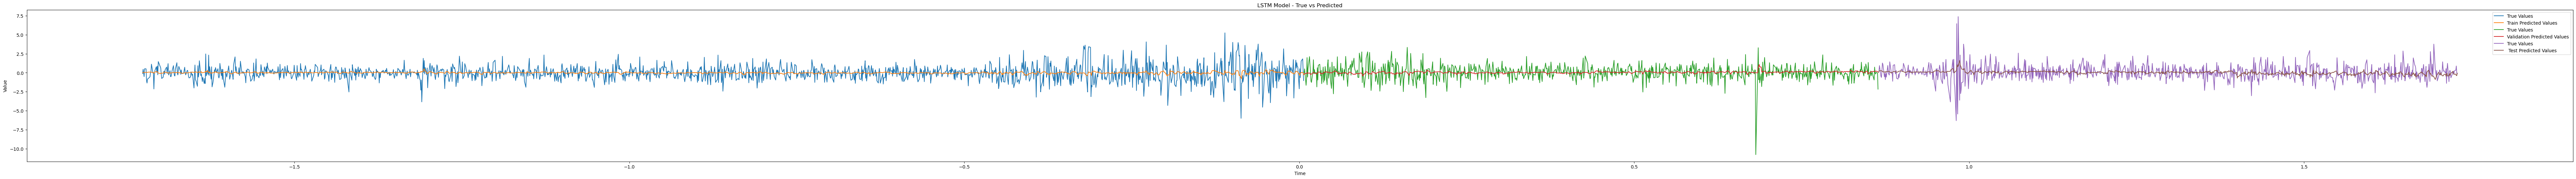

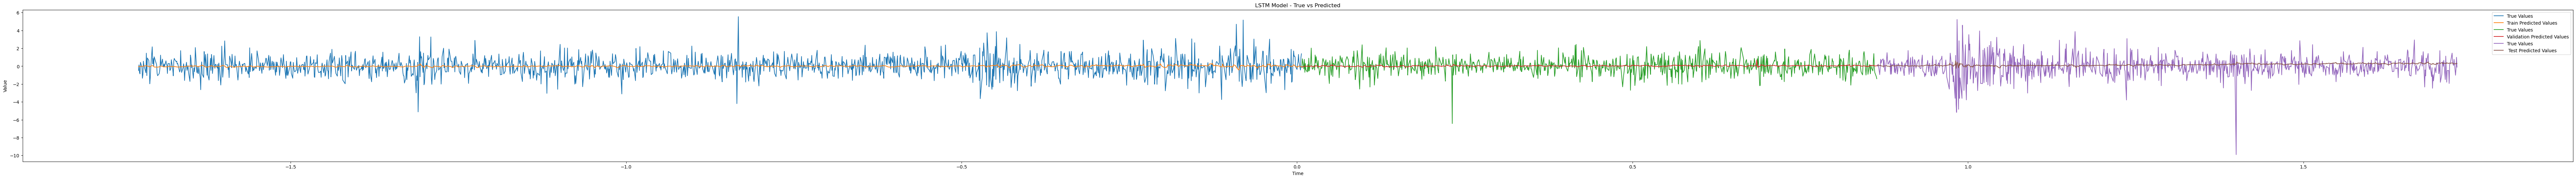

In [48]:
split_train_targets = np.array_split(train_targets,len(train_pred[0]),axis=1)
split_train_pred = np.array_split(train_pred,len(train_pred[0]),axis=1)
split_validation_targets = np.array_split(validation_targets,len(validation_pred[0]),axis=1)
split_validation_pred = np.array_split(validation_pred,len(validation_pred[0]),axis=1)
split_test_targets = np.array_split(test_targets,len(test_pred[0]),axis=1)
split_test_pred = np.array_split(test_pred,len(test_pred[0]),axis=1)


print(len(targets))
print(train_pred)
print(split_train_targets)
      
for i in range(len(targets)):
    plt.figure(i,figsize=(100, 6))
    plt.plot(df['date'][rwin:rwin+len(train_targets)], split_train_targets[i], label='True Values')
    plt.plot(df['date'][rwin:rwin+len(train_targets)], split_train_pred[i], label='Train Predicted Values')
    plt.plot(df['date'][rwin+len(train_targets):rwin+len(train_targets)+len(validation_targets)], split_validation_targets[i], label='True Values')
    plt.plot(df['date'][rwin+len(train_targets):rwin+len(train_targets)+len(validation_targets)], split_validation_pred[i], label='Validation Predicted Values')
    plt.plot(df['date'][rwin+1+len(train_targets)+len(validation_targets):], split_test_targets[i], label='True Values')
    plt.plot(df['date'][rwin+len(train_targets)+len(validation_targets):], split_test_pred[i][:-1], label=' Test Predicted Values')
    plt.title('LSTM Model - True vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [49]:
print(best_params)

{'activation': 2, 'batch': 4.0, 'denseunits': 5.0, 'epochs': 10.0, 'lstmunits': 12.0, 'ndenselayers': 1.0, 'nlstmlayers': 1.0, 'optimizer': 0}


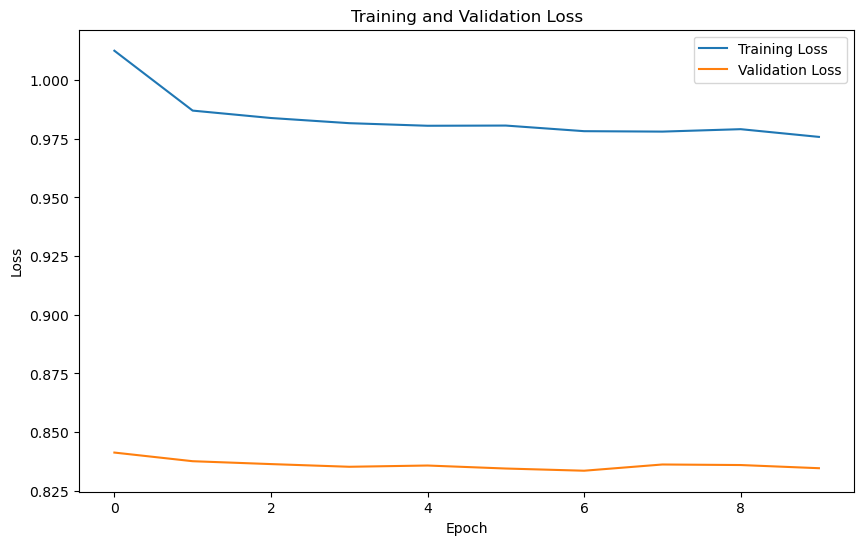

In [50]:
plot_model(model, to_file="Plots/model.png", show_shapes=True)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 

In [ ]:
%history
